# LAB 3.1 — Lane Geometry Estimation from Bird’s-Eye-View Mask
ACE Lane-Keeping System – Geometry Module  
---

## 1. Overview
This lab covers the **core geometric computations** that convert a binary lane mask (from BEV) into:

- Lateral offset of the vehicle (`pos_m`)
- Heading deviation (`head_deg`)
- Multi-ratio sampling across the lane
- Adaptive selection of the most reliable ratio

These outputs form the **input to the Adaptive Lane Controller** used in LAB 3.2.


## 2. Learning Objectives

After this lab, learner will understand:

1. How to compute lane center from BEV mask  
2. How to estimate heading using two vertical sampling points  
3. How to convert pixel width → real-world meters  
4. How multi-ratio improves robustness  
5. How to evaluate stability using windowed statistics  


## 3. Import Libraries


In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import deque

## 4. Load BEV Mask (Input from LAB 2)

In real deployment, this mask is generated from:

mask01 → ROI → morphology → BEV

For this lab, we load a sample BEV binary mask.

In [6]:
bev = cv2.imread(r"C:\Users\admin\ACE_Finalv3\debug_pipeline_out\frame_00600_4_bev.png", cv2.IMREAD_GRAYSCALE)
bev = (bev > 0).astype(np.uint8)

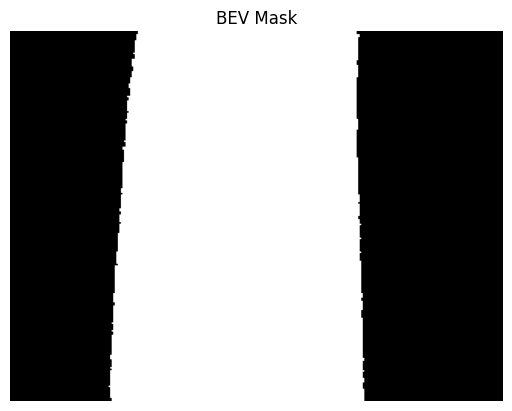

In [7]:
plt.imshow(bev, cmap='gray')
plt.title("BEV Mask")
plt.axis('off')
plt.show()

## 5. Compute Lane Width Scaling (meters_per_pixel)

To convert pixel distances into meters, we estimate lane width from the bottom row:

$$
meters\_per\_pixel = \frac{lane\_width\_m}{lane\_width\_px}
$$

We assume the physical lane width is **0.20 m** (Autocar-Kit specification).


In [8]:
def meters_per_pixel(bev, lane_width_m=0.20):
    H, W = bev.shape
    row = bev[H - 1, :]
    xs = np.where(row > 0)[0]

    if xs.size >= 2:
        width_px = float(xs[-1] - xs[0])
        width_px = max(width_px, 16.0)
        return lane_width_m / width_px
    
    return lane_width_m / max(W, 1)


## 6. Compute Lane Center Position (center_x)

After computing the lane width scaling (meters-per-pixel), the next step is to
measure the **horizontal center of the lane** at a given height in the BEV image.

For a given ratio ( r in (0,1) ):

$$
y = r \cdot H
$$

We scan the BEV mask at row \( y \) and find lane pixels:

$$
x_{\text{lane}} = \{\, x \mid bev[y, x] = 1 \,\}
$$

If at least two lane pixels exist:

$$
x_{\text{center}} = \frac{x_{\min} + x_{\max}}{2}
$$

Otherwise, we return **NaN**, indicating that the lane is not visible at that height.

In [9]:
def center_x(bev, ratio):
    H, W = bev.shape
    y = int(ratio * H)
    y = np.clip(y, 0, H - 1)

    xs = np.where(bev[y, :] > 0)[0]
    if xs.size < 2:
        return np.nan

    cx = 0.5 * (xs[0] + xs[-1])
    return float(cx)

## 7. Compute Lateral Lane Offset (posₘ)

After obtaining:

1. **Lane center** $( x_{\text{center}} $) from Cell 6
2. **Meters-per-pixel** $( mpp $) from Cell 5

we can compute the **lateral deviation** of the vehicle from the lane center.

Let the BEV image width be \( W \).  
The reference center of the vehicle is:

$$
x_{\text{ref}} = \frac{W}{2}
$$

The lateral offset in meters is:

$$
pos_m = (x_{\text{ref}} - x_{\text{center}})\,\times\, mpp
$$

Interpretation:
- $( pos_m > 0 $): vehicle is **left** of center → needs to steer **right**
- $( pos_m < 0 $): vehicle is **right** of center → needs to steer **left**

If lane center cannot be detected, return `NaN`.


In [10]:
def compute_lateral_offset(bev, ratio, mpp):
    H, W = bev.shape

    cx = center_x(bev, ratio)
    if np.isnan(cx):
        return np.nan

    x_ref = W / 2.0
    pos_m = (x_ref - cx) * mpp
    return float(pos_m)

## 8. Compute Heading Angle (θ) from BEV Geometry

To estimate the steering direction, we compute the **heading angle** of the lane based on
two points sampled at different heights of the BEV mask.

Let:

- $( y_b $) = lower sampling row  
- $( y_t $) = upper sampling row  
- $( x_b $) = lane center at $( y_b $)  
- $( x_t $) = lane center at $( y_t $)

We define:

$$
dx = x_b - x_t, \qquad dy = y_b - y_t
$$

The heading angle in degrees is:

$$
\theta = \arctan2(dx,\, dy) \cdot \frac{180}{\pi}
$$

Interpret:

- $( \theta > 0 $): lane curves **left**  
- $( \theta < 0 $): lane curves **right**  
- If either center is missing → return `NaN`

This is the same geometric formula used in major lane detection papers and is also
the one applied in your full pipeline.


In [11]:
def heading_deg_at_ratio(bev, y_ratio, dy_px=30):
    H, W = bev.shape
    yb = int(np.clip(y_ratio * H, 0, H - 1))
    yt = int(np.clip(yb - dy_px, 0, H - 1))
    # Lane centers at these rows
    xb = center_x(bev, yb / H)
    xt = center_x(bev, yt / H)
    dx = xb - xt
    dy = (yb - yt) + 1e-6

    # Convert to degrees
    heading_deg = float(np.degrees(np.arctan2(dx, dy)))

    return heading_deg, float(xb)

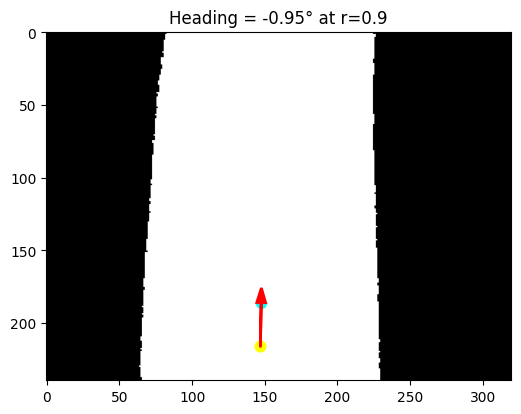

In [12]:
y_ratio = 0.90
dy_px = 30
heading, xb = heading_deg_at_ratio(bev, y_ratio, dy_px)
H, W = bev.shape
yb = int(y_ratio * H)
yt = int(max(yb - dy_px, 0))
xt = center_x(bev, yt / H)

plt.figure(figsize=(6,6))
plt.imshow(bev * 255, cmap="gray", origin="upper")
plt.scatter([xb], [yb], color="yellow", s=60)
plt.scatter([xt], [yt], color="cyan", s=50)
plt.arrow(
    xb, yb,
    (xt - xb), (yt - yb),
    color="red",
    head_width=6,
    head_length=10,
    linewidth=2
)
plt.title(f"Heading = {heading:.2f}° at r={y_ratio}")
plt.show()

## 9. Multi-Ratio Sampling (Extracting multiple measurements along the BEV)

A single measurement point (single-ratio) is often not stable enough, especially when:
- the lane is noisy
- part of the lane is missing
- the curve is sharp

Solution: **Sample multiple points at different positions in the BEV image** (multi-ratio sampling).

Given the set of sampling ratios:

$$
R = \{ r_1, r_2, r_3, \ldots \}
$$

At each ratio $( r_i $):

1. Extract lane center:
$$
x_i = center\_x(BEV, r_i)
$$

2. Compute lateral offset:
$$
pos_i = (W/2 - x_i) \cdot mpp
$$

3. Compute heading angle:
$$
head_i = heading(r_i)
$$

Result: the lists `pos_list`, `head_list`, `center_list` are used by the adaptive controller.


In [13]:
def multi_ratio_measure(bev, ratios, dy_px=30, lane_width_m=0.20):
    H, W = bev.shape
    mpp = meters_per_pixel(bev, lane_width_m)

    centers_px = []
    pos_list   = []
    head_list  = []

    for r in ratios:
        cx = center_x(bev, r)
        pos_m = (W/2 - cx) * mpp
        head_deg, _ = heading_deg_at_ratio(bev, r, dy_px)

        centers_px.append(cx)
        pos_list.append(pos_m)
        head_list.append(head_deg)

    return centers_px, pos_list, head_list

In [14]:
ratios = [0.98, 0.92, 0.82, 0.72]

centers_px, pos_list, head_list = multi_ratio_measure(
    bev, ratios=ratios, dy_px=30, lane_width_m=0.20
)

assert len(centers_px) == len(ratios)
assert len(pos_list)   == len(ratios)
assert len(head_list)  == len(ratios)

print("Multi-ratio measurement PASS ✔")
centers_px, pos_list, head_list

Multi-ratio measurement PASS ✔


([147.0, 147.0, 147.5, 147.5],
 [0.015950920245398775,
  0.015950920245398775,
  0.015337423312883437,
  0.015337423312883437],
 [0.0, -0.9548412220500405, 0.0, -0.9548412220500405])

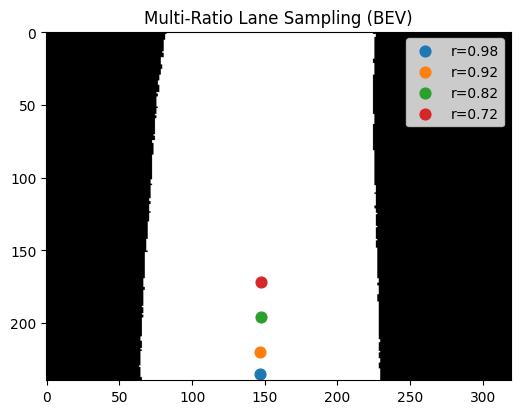

In [15]:
H = bev.shape[0]

plt.figure(figsize=(6,6))
plt.imshow(bev * 255, cmap="gray", origin="upper")

for i, cx in enumerate(centers_px):
    if not np.isnan(cx):
        y = int(ratios[i] * H)
        plt.scatter(cx, y, s=60, label=f"r={ratios[i]:.2f}")

plt.title("Multi-Ratio Lane Sampling (BEV)")
plt.legend()
plt.show()


## 10. Adaptive Ratio Selection

In the previous Multi-Ratio Cell, we extracted:
- `centers_px[r]` — lane center in pixels
- `pos_list[r]` — lateral offset in meters
- `head_list[r]` — lane heading angle

But each ratio $( r $) has different reliability:

- Some ratios see the lane clearly → stable center  
- Some ratios suffer noise or broken lanes → strong fluctuations  
- Some heights may temporarily lose the lane

Therefore, we need the **Adaptive Selection** algorithm to automatically choose the best ratio each frame.


### 1) Stability evaluation features

For each ratio $( r $):

#### ● Fluctuation of pos
$$
std\_pos = \mathrm{STD}(pos[r])
$$
Lower fluctuation → more stable → higher priority

#### ● Mean deviation of head
$$
mean\_head = \mathrm{MEAN}(head[r])
$$
A larger absolute value suggests possible noise or incorrect curvature estimation.

#### ● Visibility level (coverage)
$$
coverage = \mathrm{MEAN}(valid[r])
$$
This is the fraction of frames where the lane is visible at that position.


### 2) Meaning of W_STAB, W_HEAD, W_LAT, EPS

These are **weights used to balance stability – reliability – sampling depth**.

##### `W_STAB` — weight prioritizing stability
A large value (e.g., 2.0) means we prioritize **stable pos**, avoiding vibration or sudden center jumps.  
- Reason: ratios that give stable geometry result in more stable lane-keeping.

##### `W_HEAD` — penalty for large heading deviation
A small value (e.g., 0.1) because heading is very sensitive and should not be penalized too heavily.  
- Reason: heading naturally varies in curves → should not be punished too aggressively.

##### `W_LAT` — penalty for very high (far) ratios
A small value (0.05) used to avoid selecting regions too far away in the BEV.  
- Reason: near-field ratios give more reliable steering for stability.

##### `EPS` — anti-division-by-zero term
$$
std\_pos + \epsilon
$$
Very small (1e-6) to prevent division by zero when std_pos = 0 (perfect stability).


### 3) Combined scoring formula

$$
score(r) = 
coverage \left(
\frac{W_{stab}}{std\_pos + \epsilon} 
- W_{head} \cdot |mean\_head|
\right)
- 
W_{lat} (1 - r)
$$

Meaning:

- **more stable signal** → higher score  
- **larger heading deviation** → mild penalty  
- **lower r (closer to vehicle)** → less noise  
- **low coverage** → strong penalty (lane missing)


### 4) Optimal ratio

$$ 
r^* = \arg\max_{r} \; score(r)
$$

We then take pos & head corresponding to $( r^* $) for the controller.

→ Result: smoother, more stable, and noise-resistant vehicle behavior.


In [16]:
W_STAB, W_HEAD, W_LAT, EPS = 2.0, 0.1, 0.05, 1e-6
def adaptive_select(centers_px, pos_list, head_list, ratios, WIN=15):
    H = len(ratios)

    hist_pos  = {r: deque([pos_list[i]],  maxlen=WIN) for i, r in enumerate(ratios)}
    hist_head = {r: deque([head_list[i]], maxlen=WIN) for i, r in enumerate(ratios)}
    hist_ok   = {r: deque([0 if np.isnan(centers_px[i]) else 1], maxlen=WIN)
                 for i, r in enumerate(ratios)}

    scores = []
    for i, r in enumerate(ratios):
        std_pos   = float(np.std(hist_pos[r]))
        mean_head = float(np.mean(hist_head[r]))
        coverage  = float(np.mean(hist_ok[r]))

        score = coverage * (W_STAB/(std_pos + EPS) - W_HEAD*abs(mean_head)) \
                - W_LAT * (1.0 - r)

        scores.append(score)

    best_idx = int(np.argmax(scores))

    return {
        "best_ratio": ratios[best_idx],
        "pos": pos_list[best_idx],
        "head": head_list[best_idx],
        "scores": scores
    }


In [17]:
out = adaptive_select(
    centers_px,
    pos_list,
    head_list,
    ratios
)

print(out)

{'best_ratio': 0.98, 'pos': 0.015950920245398775, 'head': 0.0, 'scores': [1999999.999, 1999999.9005158779, 1999999.991, 1999999.8905158779]}


## 11. Summary

In this lab, you implemented:

- Lane width estimation in meters  
- Center extraction from BEV mask  
- Compute Lateral Lane Offset (posₘ)
- Compute Heading Angle (θ)
- Multi-ratio sampling  
- Adaptive selection of the best ratio  

These outputs feed directly into:

**LAB 3.2 – Adaptive Steering Control + Video Demo**
